# Windy Warehouse Environment and DQN Agent Implementation

In [9]:
import math, random
from collections import deque, namedtuple
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, Video
import imageio.v2 as imageio

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class WindyWarehouse:
    def __init__(self, grid_size=10, n_obstacles=2, wind_prob=0.05, wind_strength=1, max_steps=300):
        self.grid_size = grid_size
        self.n_obstacles = n_obstacles
        self.wind_prob = wind_prob
        self.wind_strength = wind_strength
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.agent = self._sample_empty()
        self.package = self._sample_empty(exclude={tuple(self.agent)})
        self.drop = self._sample_empty(exclude={tuple(self.agent), tuple(self.package)})
        exclude = {tuple(self.agent), tuple(self.package), tuple(self.drop)}
        self.obstacles = []
        while len(self.obstacles) < self.n_obstacles:
            pos = tuple(self._sample_empty(exclude=exclude))
            exclude.add(pos)
            self.obstacles.append(list(pos))
        self.obstacle_vel = []
        for _ in range(self.n_obstacles):
            vx, vy = random.choice([-1,0,1]), random.choice([-1,0,1])
            if vx==0 and vy==0: vx=random.choice([-1,1])
            self.obstacle_vel.append([vx,vy])
        self.has_package=False
        self.steps=0
        return self._obs()

    def step(self, action):
        self.steps+=1
        prev_agent = tuple(self.agent)
        ax, ay = self.agent
        if action==0: ay-=1
        elif action==1: ay+=1
        elif action==2: ax-=1
        elif action==3: ax+=1
        ax, ay=self._clip(ax, ay)

        if random.random()<self.wind_prob:
            wx, wy = random.choice([(1,0),(-1,0),(0,1),(0,-1)])
            ax+=self.wind_strength*wx
            ay+=self.wind_strength*wy
            ax, ay=self._clip(ax, ay)

        self.agent=[ax, ay]

        for i in range(self.n_obstacles):
            ox, oy = self.obstacles[i]
            vx, vy = self.obstacle_vel[i]
            ox+=vx; oy+=vy
            if not 0<=ox<self.grid_size: vx=-vx; ox+=2*vx
            if not 0<=oy<self.grid_size: vy=-vy; oy+=2*vy
            self.obstacles[i]=[int(np.clip(ox,0,self.grid_size-1)), int(np.clip(oy,0,self.grid_size-1))]
            self.obstacle_vel[i]=[vx,vy]

        reward=-0.05
        done=False
        info={}

        if any(ax==ox and ay==oy for ox, oy in self.obstacles):
            reward-=6.0; done=True; info['reason']='collision'

        if (ax==self.package[0] and ay==self.package[1]) and (not self.has_package):
            self.has_package=True
            reward+=10.0

        if self.has_package and (ax==self.drop[0] and ay==self.drop[1]):
            reward+=20.0 + 2.0*(1.0 - self.steps/self.max_steps)
            done=True; info['reason']='delivered'

        goal=self.package if not self.has_package else self.drop
        prev_dist=abs(prev_agent[0]-goal[0])+abs(prev_agent[1]-goal[1])
        new_dist=abs(ax-goal[0])+abs(ay-goal[1])
        if new_dist<prev_dist: reward+=0.1

        if self.steps>=self.max_steps and not done:
            reward-=2.0; done=True; info['reason']='timeout'

        return self._obs(), reward, done, info

    def _obs(self):
        denom=max(1,self.grid_size-1)
        ax, ay=self.agent; px, py=self.package; dx, dy=self.drop
        obs=[ax/denom, ay/denom, px/denom, py/denom, dx/denom, dy/denom, 1.0 if self.has_package else 0.0, (self.max_steps-self.steps)/self.max_steps]
        for ox, oy in self.obstacles: obs+=[ox/denom, oy/denom]
        return np.array(obs,dtype=np.float32)

    def _sample_empty(self, exclude=None):
        if exclude is None: exclude=set()
        while True:
            x=random.randrange(self.grid_size)
            y=random.randrange(self.grid_size)
            if (x,y) not in exclude: return [x,y]

    def _clip(self, x,y): return int(np.clip(x,0,self.grid_size-1)), int(np.clip(y,0,self.grid_size-1))

    def rgb_frame(self):
        g=self.grid_size; img=np.ones((g,g,3),dtype=np.float32)
        for ox, oy in self.obstacles: img[oy,ox]=[0.85,0.1,0.1]
        if not self.has_package: px,py=self.package; img[py,px]=[0.2,0.2,0.9]
        dx,dy=self.drop; img[dy,dx]=[0.1,0.7,0.1]
        ax,ay=self.agent; img[ay,ax]=[0.0,0.0,0.0]
        scale=32; img_up=np.repeat(np.repeat(img,scale,axis=0),scale,axis=1)
        return np.clip(img_up*255,0,255).astype(np.uint8)

Transition=namedtuple('Transition',('state','action','reward','next_state','done'))

class ReplayBuffer:
    def __init__(self, capacity=150000): self.buffer=deque(maxlen=capacity)
    def push(self,*args): self.buffer.append(Transition(*args))
    def sample(self,batch_size):
        idx=np.random.choice(len(self.buffer),batch_size,replace=False)
        batch=[self.buffer[i] for i in idx]
        states=torch.tensor(np.array([b.state for b in batch]),dtype=torch.float32,device=device)
        actions=torch.tensor(np.array([b.action for b in batch]),dtype=torch.int64,device=device).unsqueeze(-1)
        rewards=torch.tensor(np.array([b.reward for b in batch]),dtype=torch.float32,device=device).unsqueeze(-1)
        next_states=torch.tensor(np.array([b.next_state for b in batch]),dtype=torch.float32,device=device)
        dones=torch.tensor(np.array([b.done for b in batch],dtype=np.float32),device=device).unsqueeze(-1)
        return states, actions, rewards, next_states, dones
    def __len__(self): return len(self.buffer)

class DuelingQNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=256):
        super().__init__()
        self.fc1=nn.Linear(obs_dim, hidden)
        self.fc2=nn.Linear(hidden, hidden)
        self.value_fc=nn.Linear(hidden,1)
        self.adv_fc=nn.Linear(hidden, act_dim)
        self.act=nn.ReLU()

    def forward(self,x):
        h=self.act(self.fc1(x))
        h=self.act(self.fc2(h))
        value=self.value_fc(h)
        adv=self.adv_fc(h)
        q=value + (adv - adv.mean(dim=-1,keepdim=True))
        return q

class DQNAgent:
    def __init__(self, obs_dim, act_dim, config):
        self.act_dim=act_dim
        self.gamma=config['gamma']; self.batch_size=config['batch_size']
        self.lr=config['lr']; self.eps_start=config['eps_start']
        self.eps_end=config['eps_end']; self.eps_decay=config['eps_decay']
        self.tau=config.get('tau',0.01)
        self.total_steps=0; self.grad_clip=config['grad_clip']
        self.online=DuelingQNetwork(obs_dim,act_dim,hidden=config['hidden']).to(device)
        self.target=DuelingQNetwork(obs_dim,act_dim,hidden=config['hidden']).to(device)
        self.target.load_state_dict(self.online.state_dict()); self.target.eval()
        self.optim=optim.Adam(self.online.parameters(),lr=self.lr)
        self.loss_fn=nn.SmoothL1Loss()

    def epsilon(self): return self.eps_end + (self.eps_start-self.eps_end)*math.exp(-self.total_steps/self.eps_decay)

    def act(self,state,greedy=False):
        if not greedy: self.total_steps+=1
        if not greedy and random.random()<self.epsilon(): return random.randrange(self.act_dim)
        with torch.no_grad():
            s=torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)
            q=self.online(s)
            return int(torch.argmax(q,dim=-1).item())

    def soft_update(self):
        for o,t in zip(self.online.parameters(),self.target.parameters()):
            t.data = self.tau*o.data + (1-self.tau)*t.data

    def update(self,replay):
        if len(replay)<self.batch_size: return None
        states,actions,rewards,next_states,dones=replay.sample(self.batch_size)
        with torch.no_grad():
            next_a = torch.argmax(self.online(next_states), dim=-1, keepdim=True)
            target_q = self.target(next_states).gather(1,next_a)
            y = rewards + (1-dones)*self.gamma*target_q
        q_sa = self.online(states).gather(1,actions)
        loss=self.loss_fn(q_sa,y)
        self.optim.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(self.online.parameters(),self.grad_clip)
        self.optim.step()
        self.soft_update()
        return float(loss.item())

def train_and_visualize(env_cfg, agent_cfg, train_cfg):
    env = WindyWarehouse(**env_cfg)
    obs_dim = len(env._obs())
    act_dim = 5
    agent = DQNAgent(obs_dim, act_dim, agent_cfg)
    replay = ReplayBuffer(capacity=train_cfg['replay_capacity'])
    rewards_hist, success_hist, loss_hist = [], [], []

    s = env.reset()
    for _ in range(train_cfg['warmup_steps']):
        a = random.randrange(act_dim)
        ns, r, d, _ = env.step(a)
        replay.push(s, a, r, ns, float(d))
        s = ns if not d else env.reset()

    for ep in range(1, train_cfg['episodes'] + 1):
        s = env.reset()
        ep_reward = 0.0
        delivered = 0
        for t in range(env_cfg['max_steps']):
            a = agent.act(s)
            ns, r, d, info = env.step(a)
            replay.push(s, a, r, ns, float(d))
            loss = agent.update(replay)
            if loss is not None: loss_hist.append(loss)
            ep_reward += r
            s = ns
            if d:
                delivered = 1 if info['reason'] == 'delivered' else 0
                break
        rewards_hist.append(ep_reward)
        success_hist.append(delivered)
        avg_r = np.mean(rewards_hist[-train_cfg['avg_window']:])
        avg_s = np.mean(success_hist[-train_cfg['avg_window']:])
        print(f"Episode {ep}/{train_cfg['episodes']} | Reward: {ep_reward:.2f} | Delivered: {delivered} | AvgR: {avg_r:.2f} | AvgSucc: {avg_s:.2f}")

    return agent, rewards_hist, success_hist, loss_hist


# Hyperparameters and Environment Setup

In [10]:
env_cfg = {
    'grid_size': 10,
    'n_obstacles': 1,
    'wind_prob': 0.03,
    'wind_strength': 1,
    'max_steps': 300
}

agent_cfg = {
    'hidden': 256,
    'lr': 2e-4,
    'gamma': 0.99,
    'batch_size': 128,
    'grad_clip': 5.0,
    'eps_start': 1.0,
    'eps_end': 0.05,
    'eps_decay': 18000,
    'tau': 0.01
}

train_cfg = {
    'episodes': 5000,
    'warmup_steps': 6000,
    'replay_capacity': 200000,
    'record_video_path': 'windy_warehouse_eval.mp4',
    'eval_fps': 6,
    'eval_quality': 8,
    'avg_window': 80,
    'render_every': 0,
    'live_pause': 0.03
}


# Train DQN Agent and Collect Metrics

In [11]:
agent, rewards_hist, success_hist, loss_hist = train_and_visualize(env_cfg, agent_cfg, train_cfg)


Episode 1/5000 | Reward: -8.15 | Delivered: 0 | AvgR: -8.15 | AvgSucc: 0.00
Episode 2/5000 | Reward: -5.95 | Delivered: 0 | AvgR: -7.05 | AvgSucc: 0.00
Episode 3/5000 | Reward: -9.05 | Delivered: 0 | AvgR: -7.72 | AvgSucc: 0.00
Episode 4/5000 | Reward: -6.30 | Delivered: 0 | AvgR: -7.36 | AvgSucc: 0.00
Episode 5/5000 | Reward: -5.90 | Delivered: 0 | AvgR: -7.07 | AvgSucc: 0.00
Episode 6/5000 | Reward: -5.95 | Delivered: 0 | AvgR: -6.88 | AvgSucc: 0.00
Episode 7/5000 | Reward: -6.40 | Delivered: 0 | AvgR: -6.81 | AvgSucc: 0.00
Episode 8/5000 | Reward: 31.92 | Delivered: 1 | AvgR: -1.97 | AvgSucc: 0.12
Episode 9/5000 | Reward: 29.98 | Delivered: 1 | AvgR: 1.58 | AvgSucc: 0.22
Episode 10/5000 | Reward: 3.70 | Delivered: 0 | AvgR: 1.79 | AvgSucc: 0.20
Episode 11/5000 | Reward: -7.60 | Delivered: 0 | AvgR: 0.94 | AvgSucc: 0.18
Episode 12/5000 | Reward: 3.85 | Delivered: 0 | AvgR: 1.18 | AvgSucc: 0.17
Episode 13/5000 | Reward: -6.65 | Delivered: 0 | AvgR: 0.58 | AvgSucc: 0.15
Episode 14/5000

# Evaluate Trained Agent and Generate Video

In [12]:
env = WindyWarehouse(**env_cfg)
frames = []
s = env.reset()
frames.append(env.rgb_frame())

for t in range(env_cfg['max_steps']):
    a = agent.act(s, greedy=True)
    s, r, d, _ = env.step(a)
    frames.append(env.rgb_frame())
    if d:
        break

video_path = train_cfg['record_video_path']
imageio.mimsave(video_path, frames, fps=train_cfg['eval_fps'], quality=train_cfg['eval_quality'])

print("Saved video at:", video_path)
display(Video(video_path, embed=True))


Saved video at: windy_warehouse_eval.mp4


# Training Summary and Key Metrics

In [15]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

final_success_rate = np.mean(success_hist[-train_cfg['avg_window']:])
avg_reward_last = np.mean(rewards_hist[-train_cfg['avg_window']:])
best_reward = np.max(rewards_hist)
total_episodes = len(rewards_hist)

summary = {
    "Total Episodes": total_episodes,
    f"Avg Reward (Last {train_cfg['avg_window']})": round(avg_reward_last, 3),
    f"Success Rate (Last {train_cfg['avg_window']})": round(final_success_rate, 3),
    "Best Episode Reward": round(best_reward, 3),
}

df_summary = pd.DataFrame(summary.items(), columns=["Metric", "Value"])

display(HTML(df_summary.to_html(index=False)))


Metric,Value
Total Episodes,5000.000
Avg Reward (Last 80),26.666
Success Rate (Last 80),0.825
Best Episode Reward,33.217


# Reward and Success Rate Trends

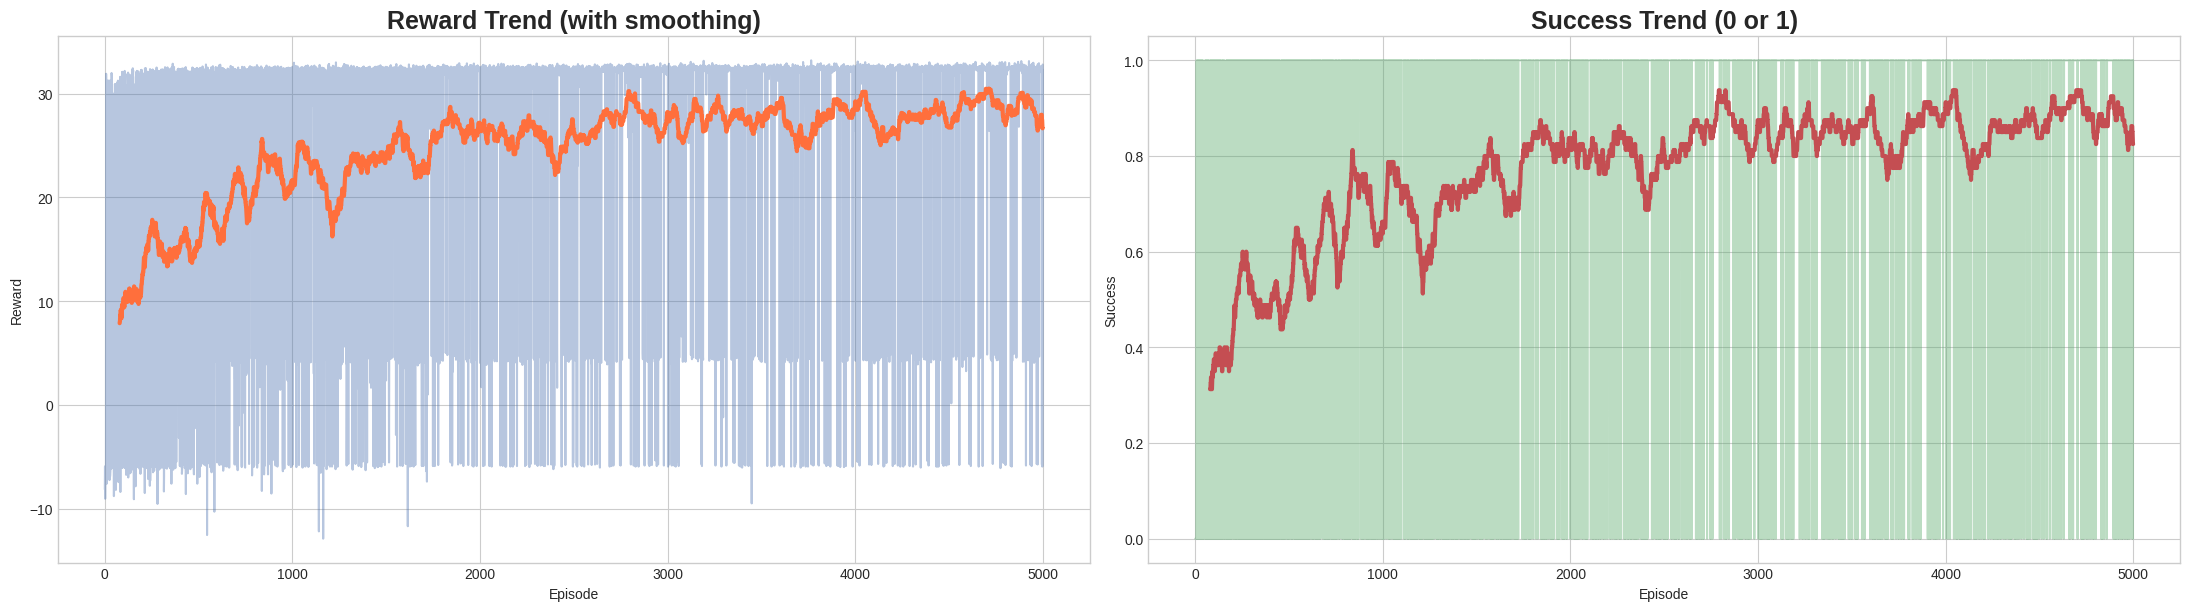

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

window = train_cfg['avg_window']
df = pd.DataFrame({
    "Episode": np.arange(len(rewards_hist)),
    "Reward": rewards_hist,
    "RewardMA": pd.Series(rewards_hist).rolling(window).mean(),
    "Success": success_hist,
    "SuccessMA": pd.Series(success_hist).rolling(window).mean(),
})

fig = plt.figure(figsize=(22, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

# ------------------ Left: Reward ------------------
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(data=df, x="Episode", y="Reward", color="#4C72B0", alpha=0.4, ax=ax1)
sns.lineplot(data=df, x="Episode", y="RewardMA", color="#FF6F3C", linewidth=3, ax=ax1)
ax1.set_title("Reward Trend (with smoothing)", fontsize=18, weight="bold")
ax1.set_ylabel("Reward")

# ------------------ Right: Success ------------------
ax2 = fig.add_subplot(gs[0, 1])
sns.lineplot(data=df, x="Episode", y="Success", color="#55A868", alpha=0.4, ax=ax2)
sns.lineplot(data=df, x="Episode", y="SuccessMA", color="#C44E52", linewidth=3, ax=ax2)
ax2.set_title("Success Trend (0 or 1)", fontsize=18, weight="bold")
ax2.set_ylabel("Success")

plt.tight_layout()
plt.show()


# Trainin Progress Heatmap

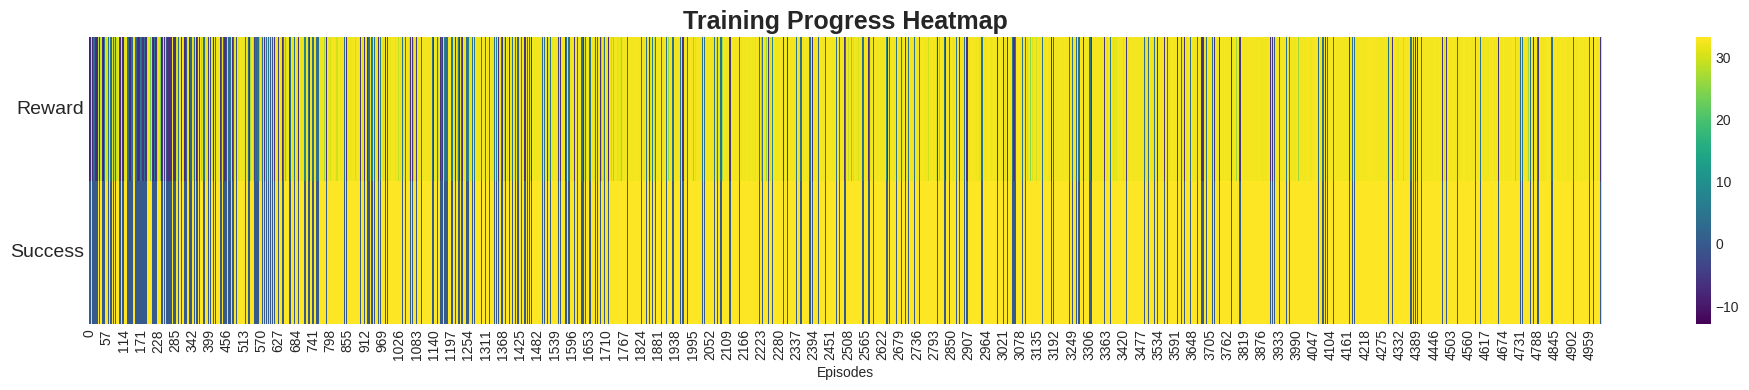

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

matrix = np.vstack([rewards_hist, success_hist]).astype(float)
matrix[1] = matrix[1] * np.max(rewards_hist)

plt.figure(figsize=(20, 4))
sns.heatmap(matrix, cmap="viridis", cbar=True)

plt.yticks([0.5, 1.5], ["Reward", "Success"], rotation=0, fontsize=14)
plt.title("Training Progress Heatmap", fontsize=18, weight="bold")
plt.xlabel("Episodes")
plt.tight_layout()
plt.show()


# Agent Training Performance Timeline

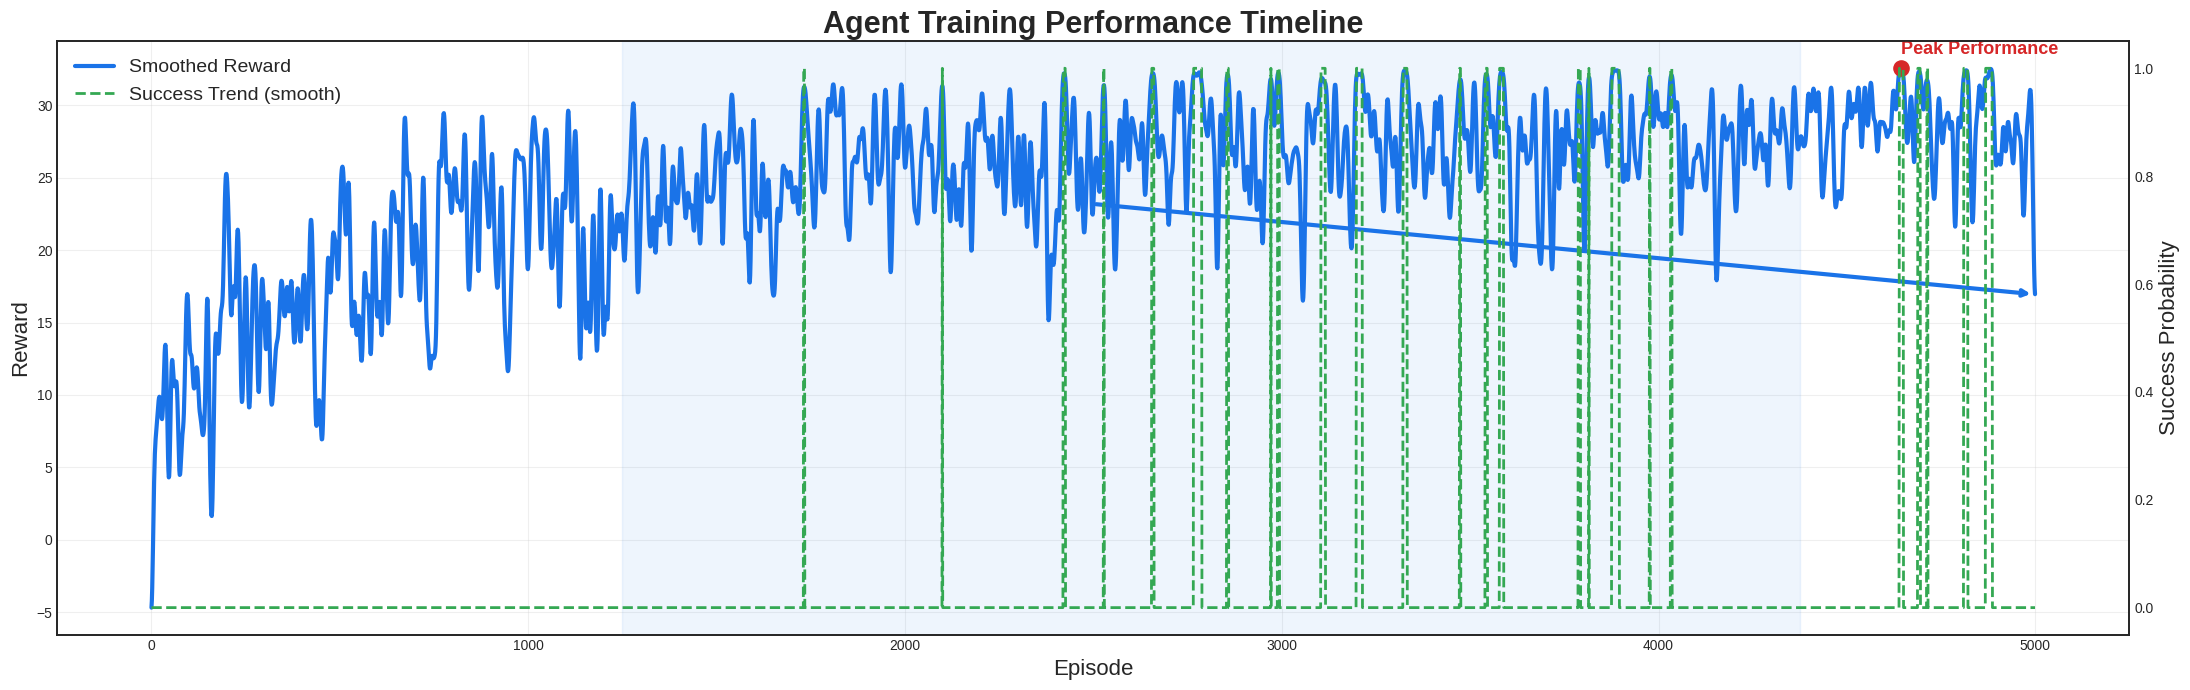

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

plt.style.use("seaborn-v0_8-white")

episodes = np.arange(len(rewards_hist))
reward_smooth = gaussian_filter1d(rewards_hist, sigma=4)
success_smooth = gaussian_filter1d(success_hist, sigma=2)
fig, ax1 = plt.subplots(figsize=(22, 7))

ax1.plot(
    episodes, reward_smooth,
    color="#1A73E8",
    linewidth=3.0,
    label="Smoothed Reward"
)

improve_start = len(reward_smooth) // 4
improve_end = len(reward_smooth) - len(reward_smooth) // 8
ax1.axvspan(
    improve_start,
    improve_end,
    alpha=0.07,
    color="#1A73E8"
)

best_ep = np.argmax(reward_smooth)
ax1.scatter(best_ep, reward_smooth[best_ep], color="#D62728", s=120, zorder=5)
ax1.text(
    best_ep, reward_smooth[best_ep] + 1,
    "Peak Performance",
    fontsize=13, color="#D62728", weight="bold"
)

ax1.annotate(
    "",
    xy=(len(episodes)-5, reward_smooth[-1]),
    xytext=(len(episodes)//2, reward_smooth[len(reward_smooth)//2]),
    arrowprops=dict(arrowstyle="->", lw=3, color="#1A73E8")
)

ax1.set_title("Agent Training Performance Timeline", fontsize=22, weight="bold")
ax1.set_xlabel("Episode", fontsize=16)
ax1.set_ylabel("Reward", fontsize=16)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(
    episodes, success_smooth,
    color="#34A853",
    linewidth=2.0,
    linestyle="--",
    label="Success Trend (smooth)"
)
ax2.set_ylabel("Success Probability", fontsize=16)

lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left", fontsize=14)

plt.tight_layout()
plt.show()
